# Problem/need: Predicting whether a non-NYPD subject involved in a force incident will be injured or not

recall = tp/ap = tp/(tp+fn)

Since false negatives (predicting that use of force doesn't result in a subject being injured when it actually does) are more costly, I'm going to weight recall more heavily than precision by using F2 as my evaluation metric.

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, fbeta_score, make_scorer, roc_auc_score, roc_curve

import imblearn.over_sampling

In [2]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project/Metis-Classification'

In [3]:
os.chdir('/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project')

# Read in NYPD Use of Force datasets

## incidents

In [4]:
incidents = pd.read_csv('NYPD_Use_of_Force_Incidents.csv')

In [5]:
incidents.shape

(13527, 7)

In [6]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13527 entries, 0 to 13526
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  13527 non-null  int64 
 1   ForceType            13527 non-null  object
 2   Occurrence Date      13527 non-null  object
 3   Incident Pct         13527 non-null  int64 
 4   Patrol Borough       13527 non-null  object
 5   YearMonthShort       13527 non-null  object
 6   BasisForEncounter    13527 non-null  object
dtypes: int64(2), object(5)
memory usage: 739.9+ KB


## members of service

In [7]:
members = pd.read_csv('NYPD_Use_of_Force__Members_of_Service.csv')

In [8]:
members.shape

(31257, 8)

In [9]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31257 entries, 0 to 31256
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   TRI Incident Number  31257 non-null  int64 
 1   ForceType            31257 non-null  object
 2   InjuryLevel          31257 non-null  object
 3   Member Injured       31257 non-null  object
 4   Rank Grouped         31257 non-null  object
 5   Assignment           31257 non-null  object
 6   Member Gender        31257 non-null  object
 7   Race                 31257 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.9+ MB


## subjects

In [10]:
subjects = pd.read_csv('NYPD_Use_of_Force__Subjects.csv')

In [11]:
subjects.shape

(13283, 8)

In [12]:
subjects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13283 entries, 0 to 13282
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRI Incident Number   13283 non-null  int64  
 1   Subject Injury Level  13283 non-null  object 
 2   Subject Injured       13283 non-null  object 
 3   Age                   12741 non-null  float64
 4   Subject Race          13283 non-null  object 
 5   Subject Gender        13283 non-null  object 
 6   Force Against MOS     13283 non-null  object 
 7   Subject Used Force    13283 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 830.3+ KB


# Brielfy analyze individual datasets

## incidents

In [13]:
incidents.columns

Index(['TRI Incident Number', 'ForceType', 'Occurrence Date', 'Incident Pct',
       'Patrol Borough', 'YearMonthShort', 'BasisForEncounter'],
      dtype='object')

In [14]:
incidents['Occurrence Date'].value_counts()

06/01/2020    82
01/01/2020    69
06/02/2020    64
05/29/2020    63
05/31/2020    51
              ..
07/18/2020     4
03/28/2021     4
07/17/2020     4
07/16/2020     2
07/06/2020     1
Name: Occurrence Date, Length: 731, dtype: int64

In [15]:
incidents['ForceType'].value_counts()

Physical Force              10172
Electrical Weapon            2855
OC Spray                      259
Impact Weapon                 142
Firearm                        88
Restraining Mesh Blanket        8
Police Canine                   3
Name: ForceType, dtype: int64

In [16]:
incidents['BasisForEncounter'].value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
NON-CRIME CALLS FOR SERVICE                95
ORDER OF PROTECTION                        95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
SEARCH WARRANT                             23
AMBUSH OF MEMBER                           23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: BasisForEncounter, dtype: int64

## members

In [17]:
members.columns

Index(['TRI Incident Number', 'ForceType', 'InjuryLevel', 'Member Injured',
       'Rank Grouped', 'Assignment', 'Member Gender', 'Race'],
      dtype='object')

In [18]:
members['InjuryLevel'].value_counts()

No Injury                      25794
Physical Injury                 5062
Substantial Physical Injury      261
Serious Physical Injury          140
Name: InjuryLevel, dtype: int64

In [19]:
members['Rank Grouped'].value_counts()

Police Officer      26512
Sergeant             2353
Detective            1251
Lieutenant            718
Other                 290
Captain                71
Deputy Inspector       26
Inspector              15
Chief                  13
RECODE                  8
Name: Rank Grouped, dtype: int64

In [20]:
members['Assignment'].value_counts()

SECTOR/RESPONSE AUTO    19003
OTHER                    6168
FIXED POST               1919
ANTI-CRIME               1897
NCO                      1122
INVESTIGATION            1055
OFF DUTY                   71
SCOOTER                    22
Name: Assignment, dtype: int64

In [21]:
members['Member Gender'].value_counts()

MALE      27817
FEMALE     3440
Name: Member Gender, dtype: int64

In [22]:
members['Race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: Race, dtype: int64

## subjects

In [23]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

In [24]:
subjects['Subject Injury Level'].value_counts()

No Injury                      8988
Physical Injury                4009
Substantial Physical Injury     151
Serious Physical Injury         115
Death                            20
Name: Subject Injury Level, dtype: int64

In [25]:
subjects['Force Against MOS'].value_counts()

Physical Force        11552
No Force               1434
Displayed Weapon        158
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: Force Against MOS, dtype: int64

In [26]:
subjects['Subject Race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: Subject Race, dtype: int64

In [27]:
subjects.columns

Index(['TRI Incident Number', 'Subject Injury Level', 'Subject Injured', 'Age',
       'Subject Race', 'Subject Gender', 'Force Against MOS',
       'Subject Used Force'],
      dtype='object')

# Feature Types

* **Incident** features: general information about ___all___ incidents involving NYPD use of force. Examples: the force type, incident date, incident precinct, the patrol borough, and the basis for encounter.
* **Subject** features: information about specific subjects involved in use of force incidents. Examples: age, race, whether subject used force against a member of service, type of force used against member of service (if any). 
* **Member of Service** features: information about specific members of service involved in use of force incidents. Examples: force type, whether member of service was injured, injury level, ranking group, assignment, gender, race. 
* **Incident-Subject-Member of Service** features: information about specific incidents involving subjects and members of service. Examples: number of subjects involved in an incident, number of members of service involved in an incident.

# Clean individual datasets

In [28]:
# clean up column names in datasets

incidents.columns = incidents.columns.str.lower().str.replace(' ','_')
members.columns = members.columns.str.lower().str.replace(' ','_')
subjects.columns = subjects.columns.str.lower().str.replace(' ','_')

In [29]:
incidents['occurrence_date_rev'] = pd.to_datetime(incidents['occurrence_date'])

In [30]:
incidents['occurrence_date_rev'].min()

Timestamp('2020-01-01 00:00:00')

In [31]:
incidents['occurrence_date_rev'].max()

Timestamp('2021-12-31 00:00:00')

In [32]:
incidents['year'] = incidents['occurrence_date_rev'].dt.year
incidents['month'] = incidents['occurrence_date_rev'].dt.month

In [33]:
incidents.drop(['occurrence_date', 'yearmonthshort'],axis=1,inplace=True)

# Constructing the observations

Each observation = a subject-incident pair

In [34]:
# create df that only includes tri_incident_numbers in subjects dataset that are also in members dataset

members_tri_ids = members['tri_incident_number'].unique()
subjects_df = subjects[subjects['tri_incident_number'].isin(members_tri_ids)]

In [35]:
subjects.shape

(13283, 8)

In [36]:
subjects_df.shape

(13230, 8)

In [37]:
subjects_df['tri_incident_number'].nunique()

12589

In [38]:
subjects_df.columns

Index(['tri_incident_number', 'subject_injury_level', 'subject_injured', 'age',
       'subject_race', 'subject_gender', 'force_against_mos',
       'subject_used_force'],
      dtype='object')

In [39]:
# add column to assign index to each subject

subjects_df.reset_index(inplace=True)
subjects_df = subjects_df.rename(columns = {'index':'subject_id'})

In [40]:
subjects_df.head()

,subject_id,tri_incident_number,subject_injury_level,subject_injured,age,subject_race,subject_gender,force_against_mos,subject_used_force
0,0,2020020962054,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
1,1,2020020962062,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
2,2,2020024962101,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
3,3,2020024962121,No Injury,N,28.0,BLACK,MALE,Physical Force,Y
4,4,2020028962025,No Injury,N,28.0,BLACK,MALE,Physical Force,Y


# Constructing the features

### 1st feature: Whether the non-NYPD subject used force or not against the member of service (mos)

In [41]:
subjects_df = pd.get_dummies(subjects_df, columns=['subject_used_force'], drop_first=True)

In [42]:
# create df of subject_id, tri_incident_number and first feature

df_X = subjects_df[['subject_id','tri_incident_number','subject_used_force_Y']]
df_X.shape

(13230, 3)

### 2nd feature: type of force used by member of service (categorical, with reference category = Electrical Weapon)

In [43]:
incidents = pd.get_dummies(incidents, columns=['forcetype'], drop_first=True)

In [44]:
incidents_tri_forcetype = incidents[['tri_incident_number','forcetype_Firearm','forcetype_Impact Weapon',
                                     'forcetype_OC Spray','forcetype_Physical Force','forcetype_Police Canine',
                                     'forcetype_Restraining Mesh Blanket']]

df_X = df_X.merge(incidents_tri_forcetype, on='tri_incident_number')

In [45]:
df_X.head()

,subject_id,tri_incident_number,subject_used_force_Y,forcetype_Firearm,forcetype_Impact Weapon,forcetype_OC Spray,forcetype_Physical Force,forcetype_Police Canine,forcetype_Restraining Mesh Blanket
0,0,2020020962054,1,0,0,0,0,0,0
1,1,2020020962062,1,0,0,1,0,0,0
2,2,2020024962101,1,0,1,0,0,0,0
3,3,2020024962121,1,0,0,0,1,0,0
4,4,2020028962025,1,0,0,0,1,0,0


### 3rd feature: whether 1+ member of service got injured (binary)

In [46]:
members['member_injured'].value_counts()

N    25794
Y     5463
Name: member_injured, dtype: int64

In [47]:
members['member_injured_rev'] = members['member_injured'].apply(lambda x: 1 if x == 'Y' else 0)
members_tri_member_injured = (members.groupby('tri_incident_number',as_index=False)['member_injured_rev'].sum())

member_injured_feature = ['num_members_injured']

members_tri_member_injured.columns = ['tri_incident_number'] + member_injured_feature

df_X = df_X.merge(members_tri_member_injured, on='tri_incident_number')

### 4th feature: patrol borough of incident

In [48]:
incidents = pd.get_dummies(incidents, columns=['patrol_borough'], drop_first=True)

In [49]:
incidents_tri_patrol_borough = incidents[['tri_incident_number','patrol_borough_PBBS','patrol_borough_PBBX',
                                     'patrol_borough_PBMN', 'patrol_borough_PBMS','patrol_borough_PBQN',
                                     'patrol_borough_PBQS', 'patrol_borough_PBSI']]

df_X = df_X.merge(incidents_tri_patrol_borough, on='tri_incident_number')

### 5th feature: non-NYPD subject's race

In [50]:
# assign 'WHITE' to be the reference category

subject_race = pd.get_dummies(subjects_df.subject_race, prefix='subject_race').drop('subject_race_WHITE',axis=1)

In [51]:
subjects_tri_race = pd.concat([subjects_df.subject_id,subject_race],axis=1)

df_X = df_X.merge(subjects_tri_race, on='subject_id')

### 6th feature: type of force used by non-NYPD subject (if any)

In [52]:
subjects_df['force_against_mos'].value_counts()

Physical Force        11534
No Force               1400
Displayed Weapon        157
Impact Weapon           100
Firearm                  22
Cutting Instrument       17
Name: force_against_mos, dtype: int64

In [53]:
force_against_mos = pd.get_dummies(subjects_df.force_against_mos,prefix='force_against_mos').drop('force_against_mos_No Force',axis=1)

In [54]:
subjects_tri_forcetype = pd.concat([subjects_df.subject_id,force_against_mos],axis=1)

df_X = df_X.merge(subjects_tri_forcetype, on='subject_id')

### 7th feature: basis for encounter

In [55]:
incidents.basisforencounter.value_counts()

CRIME/VIOLATION IN PROGRESS              5279
PERSON IN CRISIS                         3235
OTHER                                    1273
PRISONER                                 1092
CROWD CONTROL                             526
VTL INFRACTION                            441
WANTED SUSPECT (E.G. WARRANT, I CARD)     437
PAST CRIME/VIOLATION                      402
SUSPICIOUS ACTIVITY                       226
DETECTIVE INVESTIGATION                   140
TRANSIT EJECTION                          104
NON-CRIME CALLS FOR SERVICE                95
ORDER OF PROTECTION                        95
IN CUSTODY INJURY                          71
HOME VISIT                                 38
SEARCH WARRANT                             23
AMBUSH OF MEMBER                           23
ANIMAL CONDITION                           14
HOSTAGE/BARRICADED                         13
Name: basisforencounter, dtype: int64

In [56]:
# assign 'OTHER' to be the reference category

basis_encounter = pd.get_dummies(incidents.basisforencounter, prefix='basis_encounter').drop('basis_encounter_OTHER',axis=1)

In [57]:
incidents_tri_basis_encounter = pd.concat([incidents.tri_incident_number,basis_encounter],axis=1)

df_X = df_X.merge(incidents_tri_basis_encounter, on='tri_incident_number')

### 8th feature: number of member(s) of service

In [58]:
# add column to assign index to each member of service

members.reset_index(inplace=True)
members = members.rename(columns = {'index':'mos_id'})

In [59]:
members_tri_member_count = (members.groupby('tri_incident_number',as_index=False)['mos_id'].count())

member_count_feature = ['num_members']

members_tri_member_count.columns = ['tri_incident_number'] + member_count_feature

df_X = df_X.merge(members_tri_member_count, on='tri_incident_number')

### 9th feature: non-NYPD subject's age

In [60]:
# assign median age to rows with nan

subjects_df['age'].fillna(subjects_df['age'].median(),inplace=True)

In [61]:
subjects_age = subjects_df[['subject_id','age']]
subjects_age = subjects_age.rename(columns = {'age':'subject_age'})
df_X = df_X.merge(subjects_age,on='subject_id')

### 10th feature: the race of the non-NYPD subject and all mos is different¶ (binary)

In [62]:
subjects['subject_race'].value_counts()

BLACK          7386
HISPANIC       3841
WHITE          1167
UNK/OTH         531
ASIAN           329
AMER INDIAN      29
Name: subject_race, dtype: int64

In [63]:
members['race'].value_counts()

WHITE          14767
HISPANIC       10001
BLACK           3775
ASIAN           2673
AMER INDIAN       25
OTH/UNK           16
Name: race, dtype: int64

In [64]:
# change 'OTH/UNK' category in members' race column so it matches the category in subjects' race column

members.loc[members.race == 'OTH/UNK', 'race'] = 'UNK/OTH'

In [65]:
# add column to assign index to each subject in subjects

subjects.reset_index(inplace=True)
subjects = subjects.rename(columns = {'index':'subject_id'})

In [66]:
# merge 

subjects_race = subjects[['subject_id','subject_race']]
df_X = df_X.merge(subjects_race,on='subject_id')

In [67]:
members_tri_race = (members.groupby('tri_incident_number', as_index=False)
               .agg({'race': (lambda x: set(x))})
               .rename(columns={'race': 'mos_race_set'}))

df_X = df_X.merge(members_tri_race, on='tri_incident_number')
df_X['subject_mos_race_diff'] = (df_X.apply(lambda row: row['subject_race'] not in row['mos_race_set'], axis=1).astype(int))

In [68]:
df_X = pd.get_dummies(df_X, columns=['subject_mos_race_diff'], drop_first=True)

In [69]:
# drop subject_race and mos_race_set columns that were only needed to create subject_mos_race_diff

df_X.drop(['subject_race','mos_race_set'],axis=1,inplace=True)

### 11th feature: # of non-NYPD subjects per incident

In [70]:
subjects_count = (subjects_df.groupby('tri_incident_number',as_index=False)['subject_id']
                  .count().rename(columns={'subject_id': 'num_subjects'}))
df_X = df_X.merge(subjects_count,on='tri_incident_number')

### 12th feature: non-NYPD subject's gender

In [71]:
subject_gender = pd.get_dummies(subjects_df.subject_gender, prefix='subject_gender').drop('subject_gender_UNK',axis=1)

In [72]:
subjects_id_gender = pd.concat([subjects_df.subject_id,subject_gender],axis=1)
df_X = df_X.merge(subjects_id_gender,on='subject_id')

# Constructing the observations' target values

In [73]:
subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13230 entries, 0 to 13229
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            13230 non-null  int64  
 1   tri_incident_number   13230 non-null  int64  
 2   subject_injury_level  13230 non-null  object 
 3   subject_injured       13230 non-null  object 
 4   age                   13230 non-null  float64
 5   subject_race          13230 non-null  object 
 6   subject_gender        13230 non-null  object 
 7   force_against_mos     13230 non-null  object 
 8   subject_used_force_Y  13230 non-null  uint8  
dtypes: float64(1), int64(2), object(5), uint8(1)
memory usage: 839.9+ KB


In [74]:
subjects_df['subject_injury_level'].value_counts()

No Injury                      8960
Physical Injury                3992
Substantial Physical Injury     146
Serious Physical Injury         112
Death                            20
Name: subject_injury_level, dtype: int64

In [75]:
# convert 'subject_injured' to 1s and 0s

injuries = ['Substantial Physical Injury','Serious Physical Injury','Death']
subjects_df['subject_injured'] = subjects_df['subject_injury_level'].apply(lambda x: 1 if x in injuries else 0)

In [76]:
subjects_tri_injured = subjects_df[['subject_id','tri_incident_number','subject_injured']]

In [77]:
subjects_tri_injured.shape

(13230, 3)

In [78]:
# create target variable

df_X = df_X.merge(subjects_tri_injured, how='left',on='subject_id')

In [79]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13230 entries, 0 to 13229
Data columns (total 53 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   subject_id                                             13230 non-null  int64  
 1   tri_incident_number_x                                  13230 non-null  int64  
 2   subject_used_force_Y                                   13230 non-null  uint8  
 3   forcetype_Firearm                                      13230 non-null  uint8  
 4   forcetype_Impact Weapon                                13230 non-null  uint8  
 5   forcetype_OC Spray                                     13230 non-null  uint8  
 6   forcetype_Physical Force                               13230 non-null  uint8  
 7   forcetype_Police Canine                                13230 non-null  uint8  
 8   forcetype_Restraining Mesh Blanket            

In [80]:
df_X.drop(['tri_incident_number_y'],axis=1,inplace=True)

In [81]:
df_X.rename(columns={"tri_incident_number_x": "tri_incident_number"}, inplace=True)

# EDA

0    0.978987
1    0.021013
Name: subject_injured, dtype: float64


<AxesSubplot:>

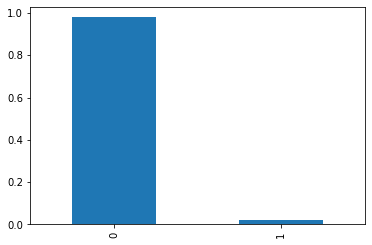

In [82]:
# check how imbalanced the target variable is

target_pcts = df_X.subject_injured.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar') # about 98% to 2% split

In [83]:
# create a helper function for plotting feature(s) vs target variable 

def plot_features(df, sample_size=500):
    
    sample = (df.sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='subject_injured', plot_kws=dict(alpha=.3, edgecolor='none'))

In [84]:
df_X.columns

Index(['subject_id', 'tri_incident_number', 'subject_used_force_Y',
       'forcetype_Firearm', 'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket', 'num_members_injured',
       'patrol_borough_PBBS', 'patrol_borough_PBBX', 'patrol_borough_PBMN',
       'patrol_borough_PBMS', 'patrol_borough_PBQN', 'patrol_borough_PBQS',
       'patrol_borough_PBSI', 'subject_race_AMER INDIAN', 'subject_race_ASIAN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGA

### Pair plots of target variable and numeric features

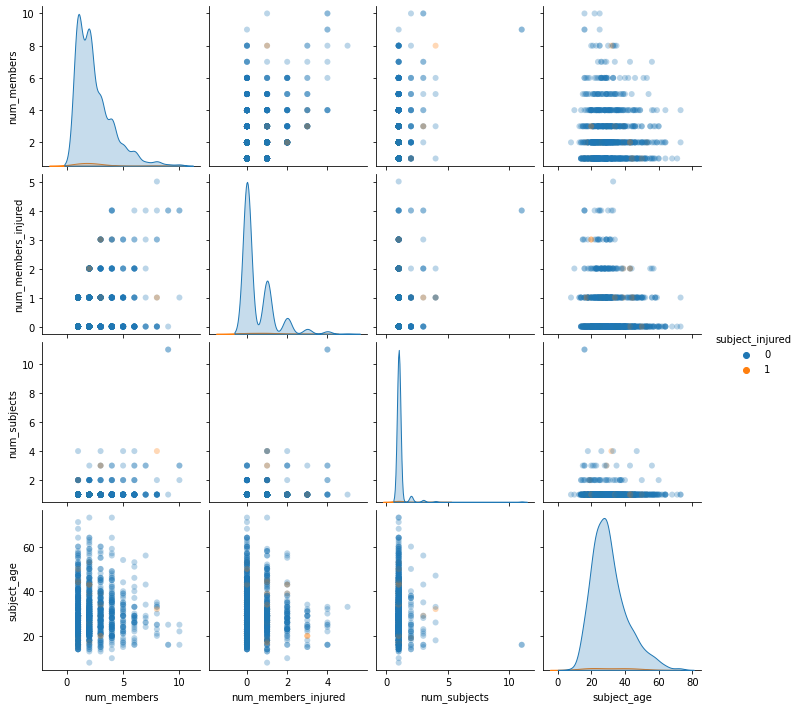

In [85]:
plot_features(df_X[['subject_injured','num_members','num_members_injured','num_subjects','subject_age']])

### Pair plot of target variable and non-NYPD subject used force feature

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


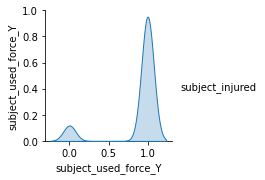

In [86]:
plot_features(df_X[['subject_injured','subject_used_force_Y',]])

### Pair plots of target variable and type of force used by member(s) of service

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


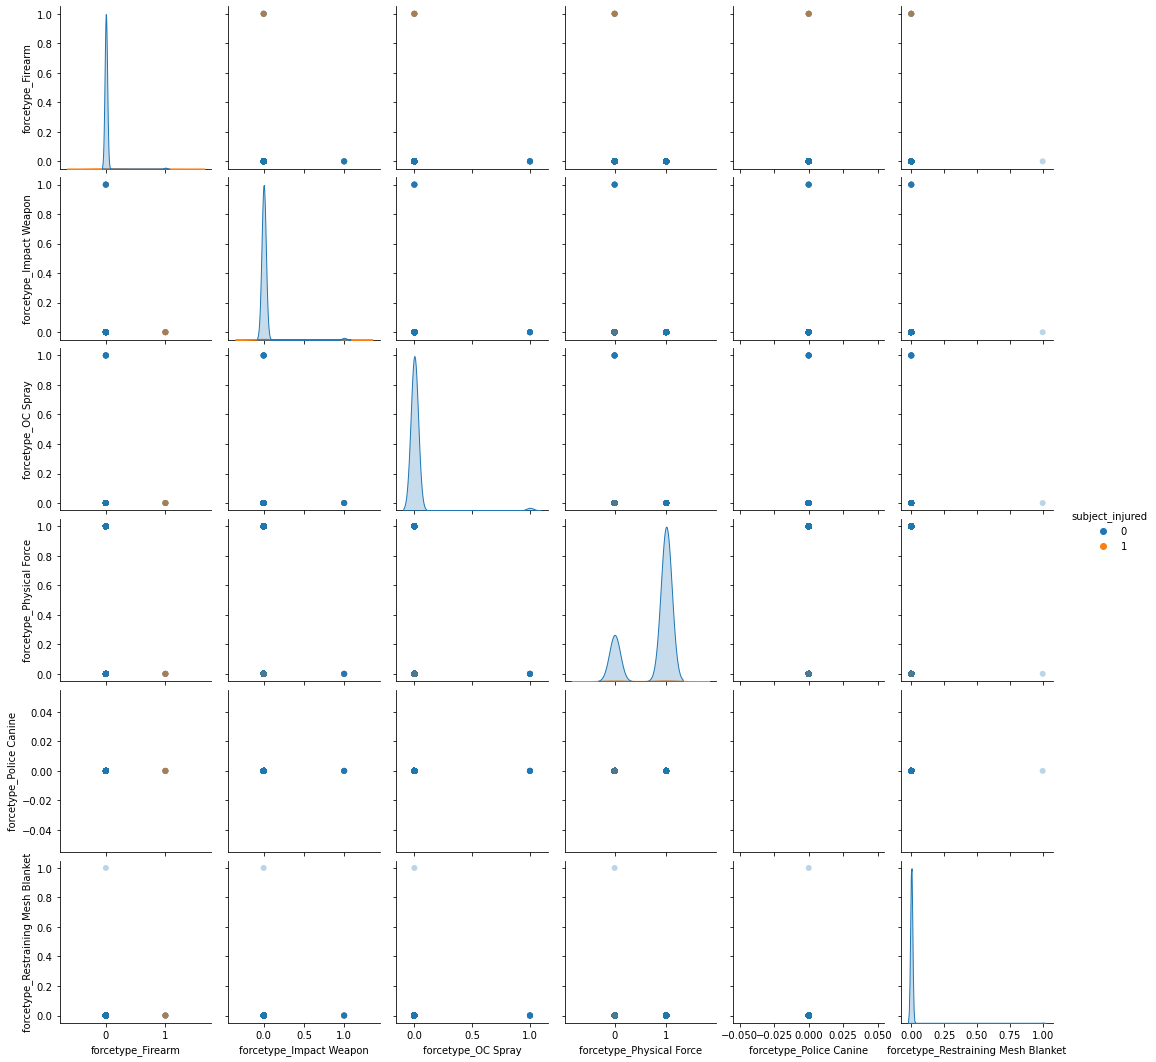

In [87]:
plot_features(df_X[['subject_injured','forcetype_Firearm', 'forcetype_Impact Weapon', 'forcetype_OC Spray',
       'forcetype_Physical Force', 'forcetype_Police Canine',
       'forcetype_Restraining Mesh Blanket']])

### Pair plots of target variable and patrol borough of incident

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


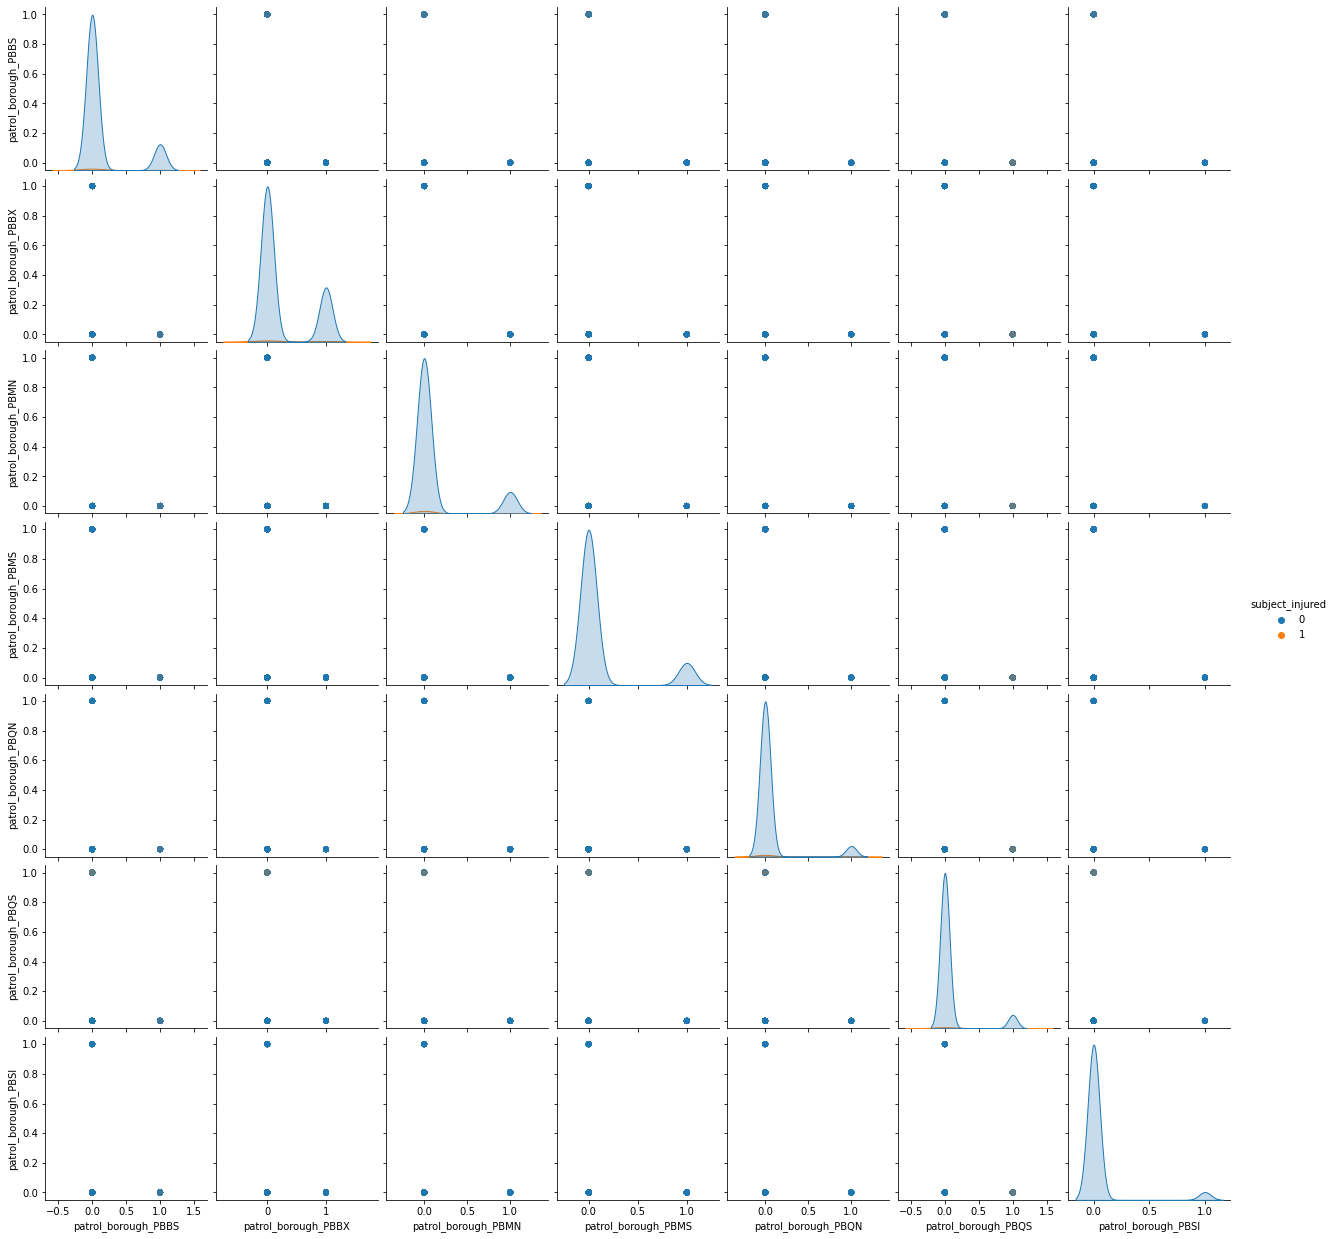

In [88]:
plot_features(df_X[['subject_injured','patrol_borough_PBBS', 'patrol_borough_PBBX', 'patrol_borough_PBMN',
       'patrol_borough_PBMS', 'patrol_borough_PBQN', 'patrol_borough_PBQS',
       'patrol_borough_PBSI']])

### Pair plots of target variable and non-NYPD subject's race

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


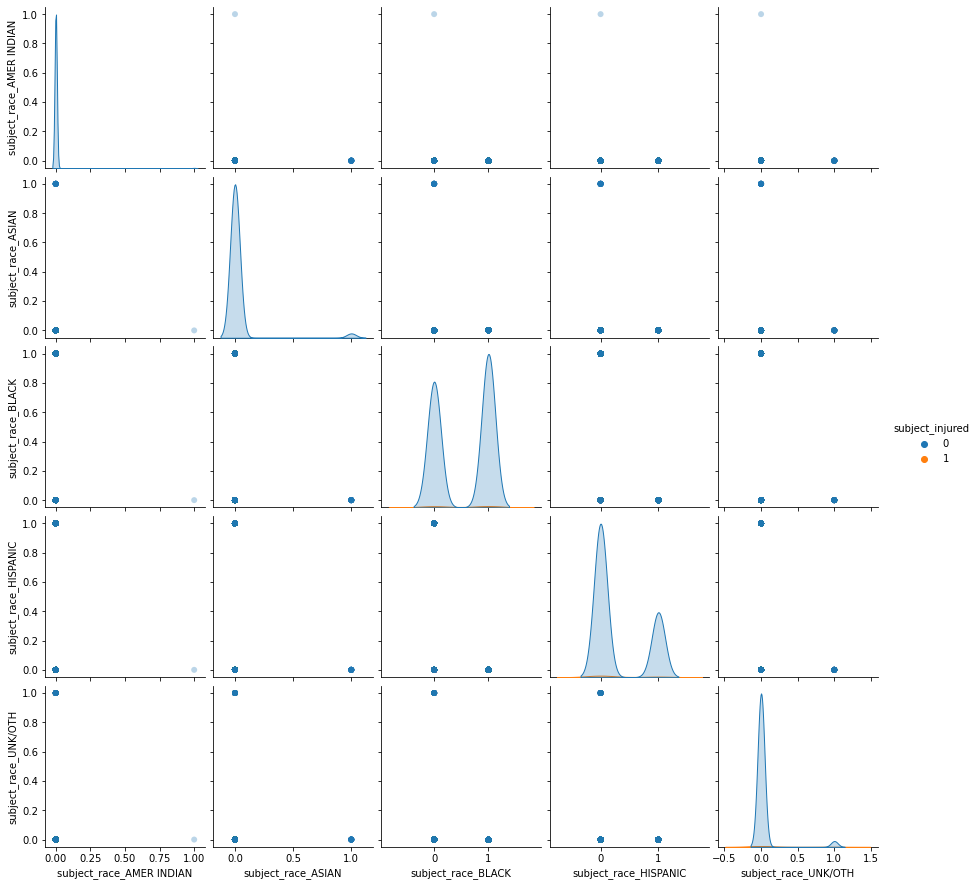

In [90]:
plot_features(df_X[['subject_injured','subject_race_AMER INDIAN', 'subject_race_ASIAN',
       'subject_race_BLACK', 'subject_race_HISPANIC', 'subject_race_UNK/OTH']])

### Pair plots of target variable and type of force, if any, used against member(s) of service

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


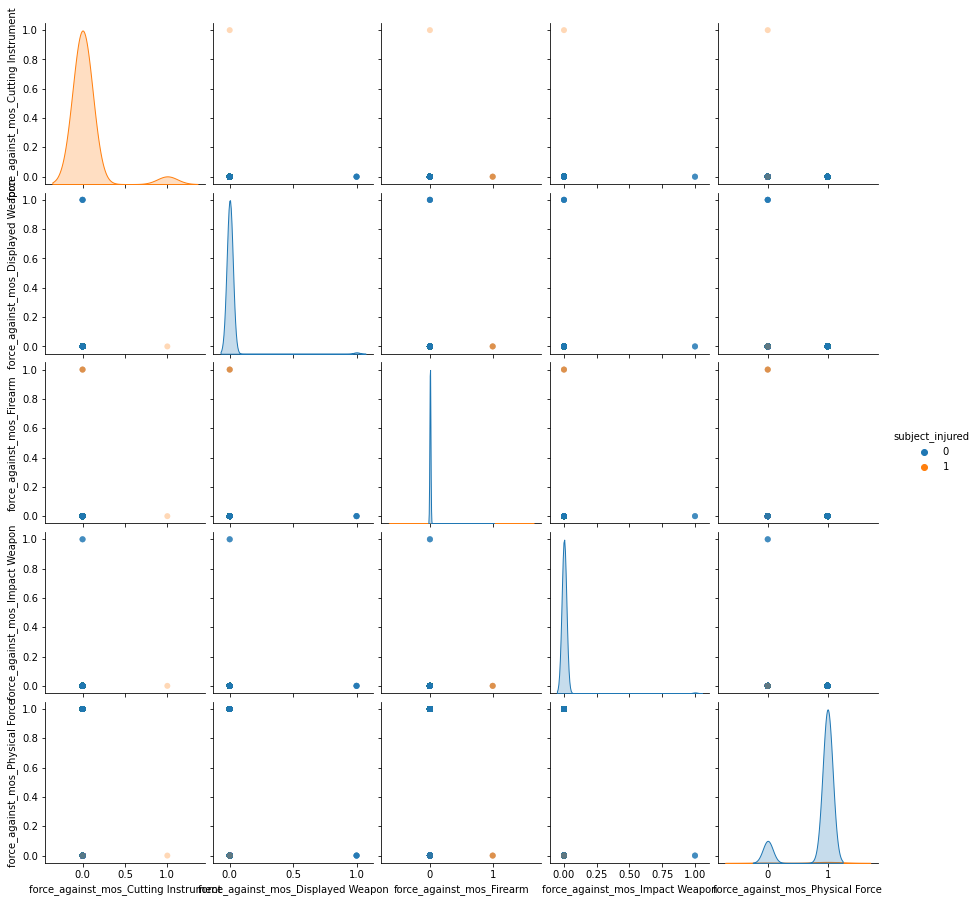

In [91]:
plot_features(df_X[['subject_injured','force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']])

### Pair plots of target variable and 9 of the 19 bases for encounter

In [104]:
incidents['basisforencounter'].nunique()

19

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


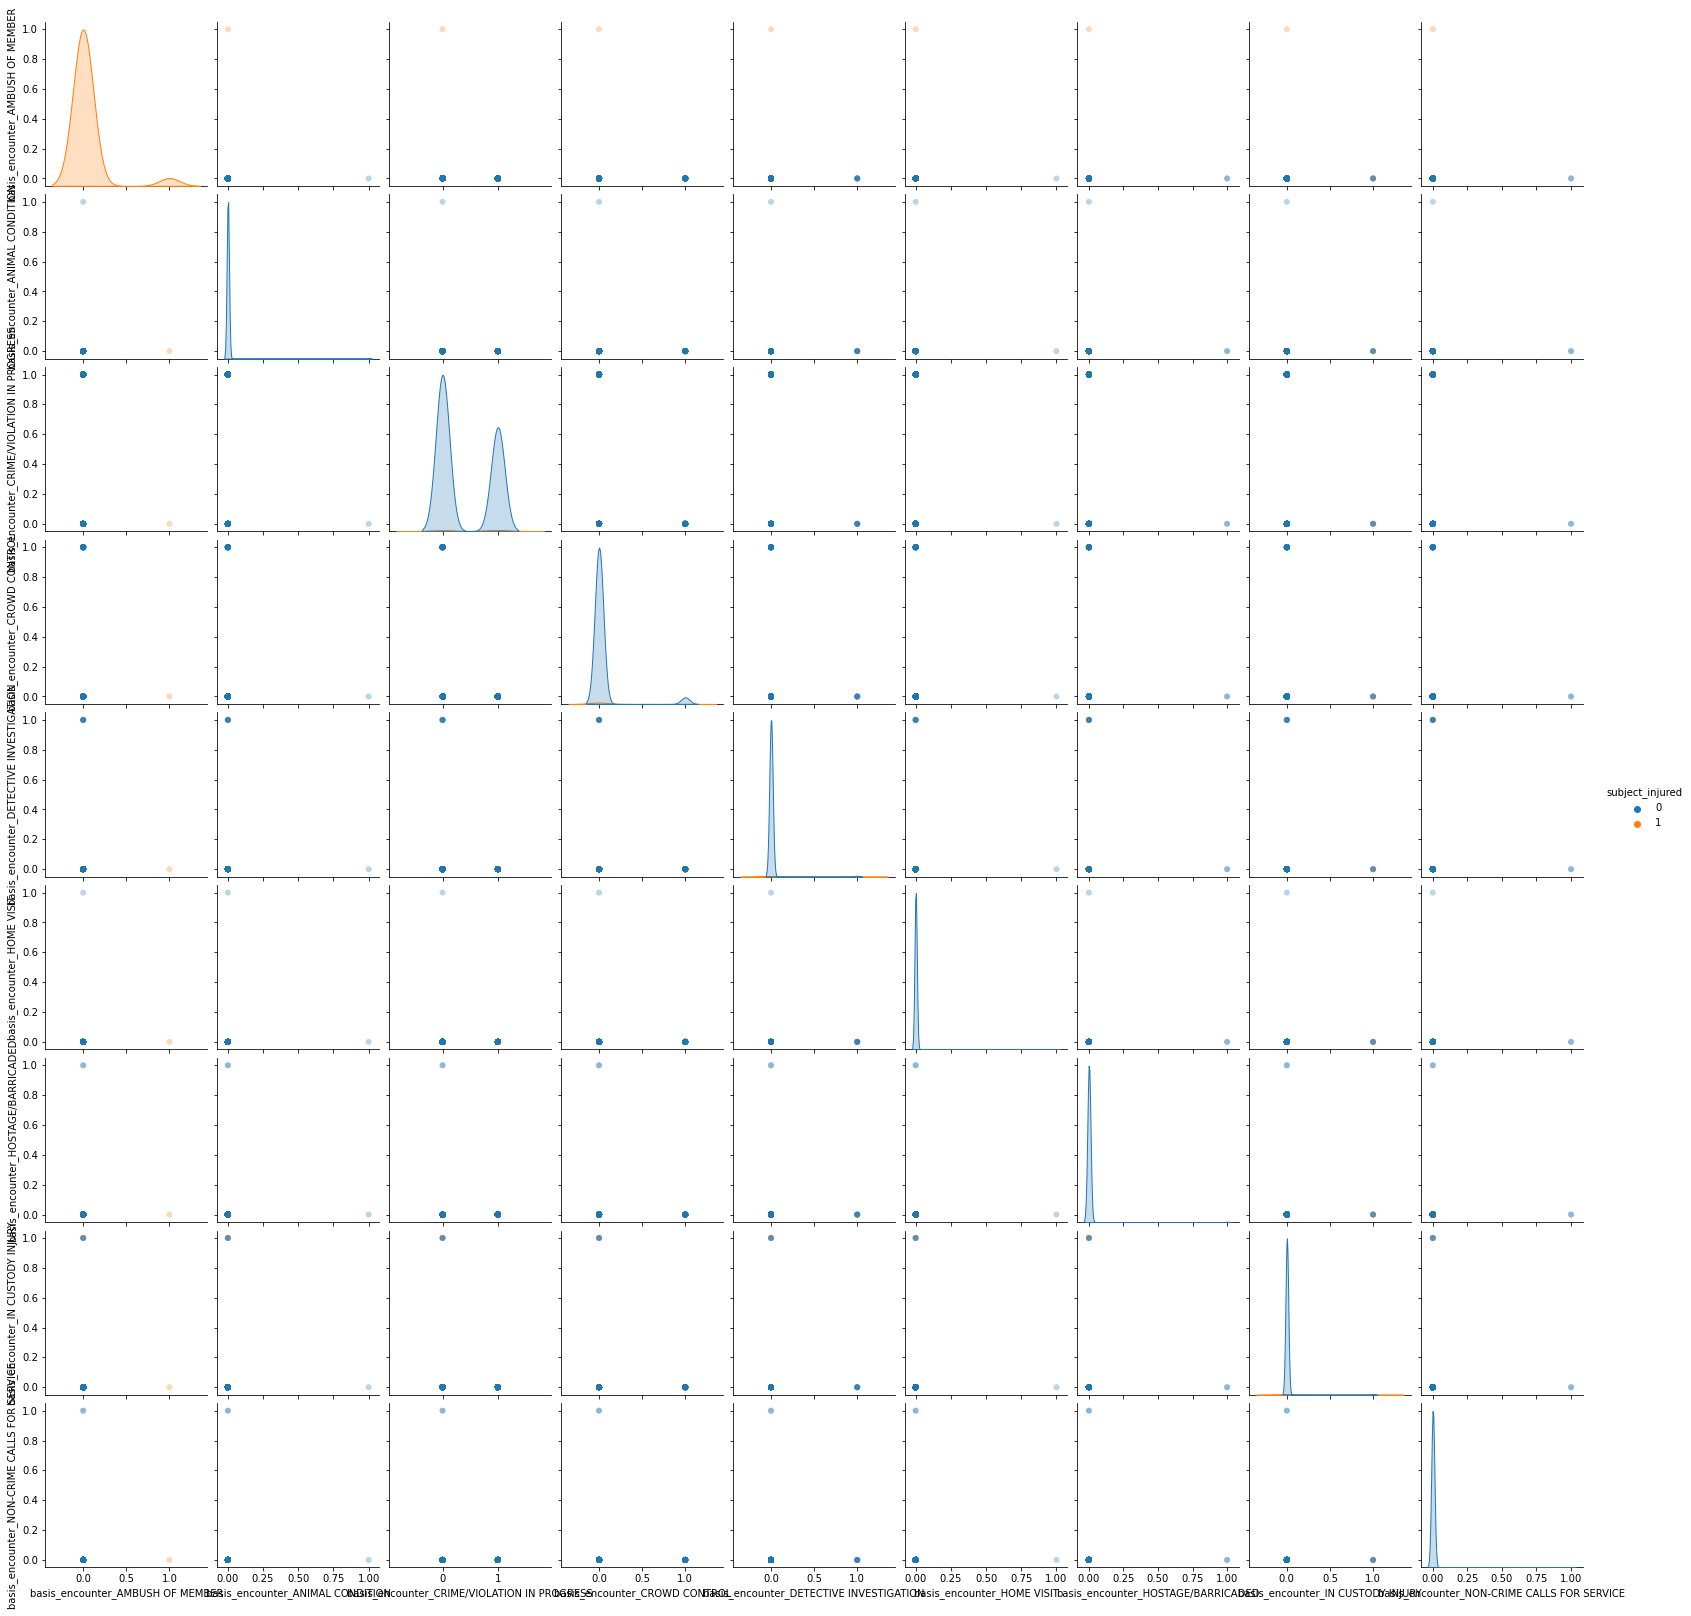

In [92]:
plot_features(df_X[['subject_injured','basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS','basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED','basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE']])

### Pair plots of target variable and last 10 of the 19 bases for encounter

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWa

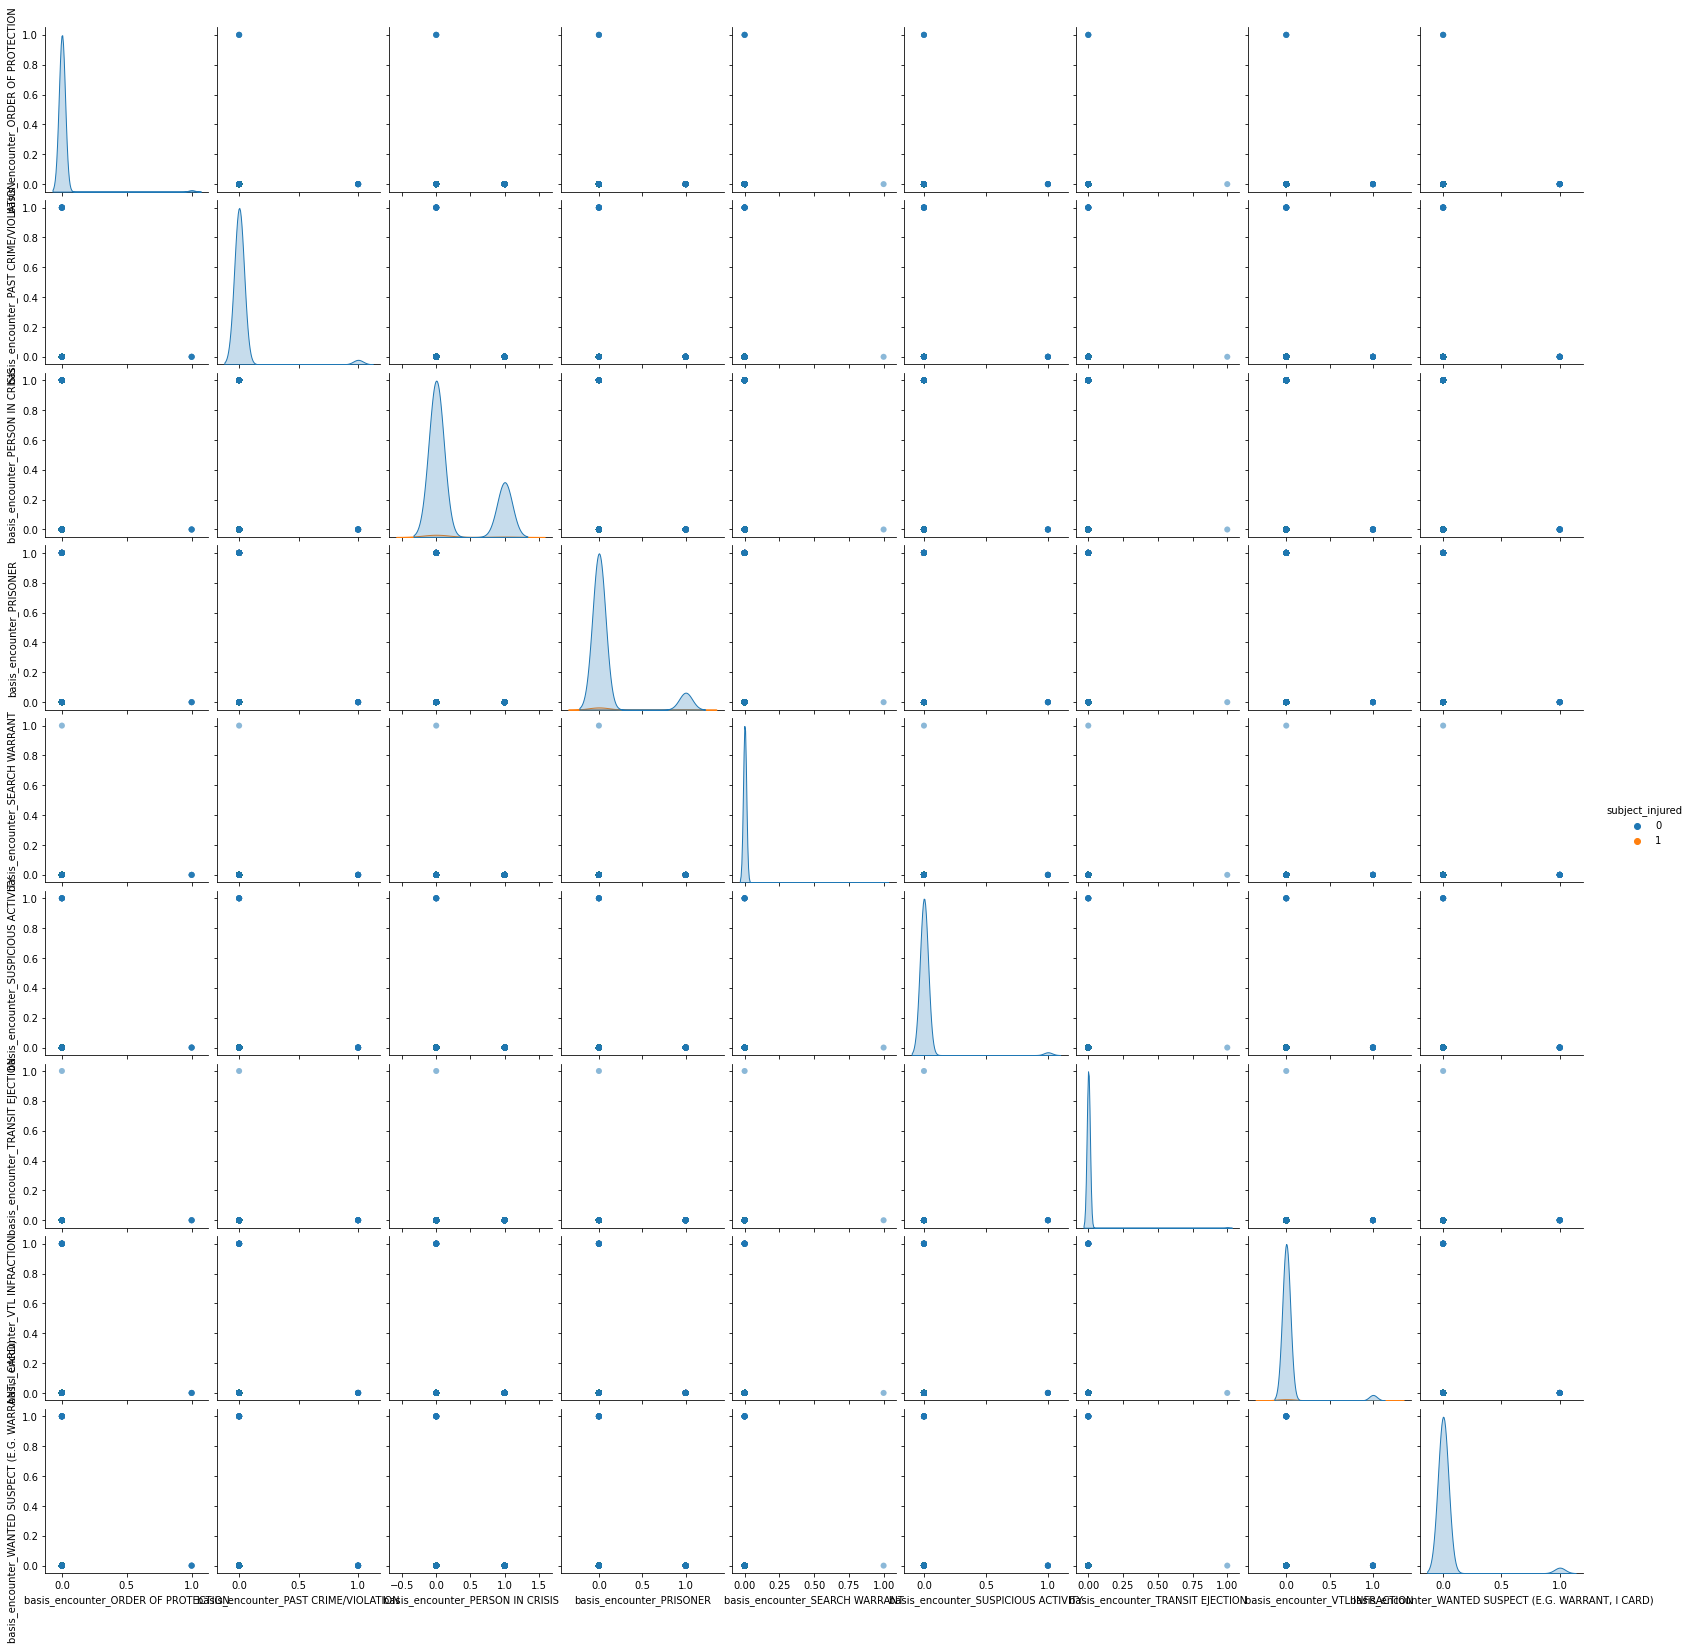

In [93]:
plot_features(df_X[['subject_injured',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']])

### Pair plot of target variable and rade of non-NYPD subject different from race of 1+ members of service involved in incident

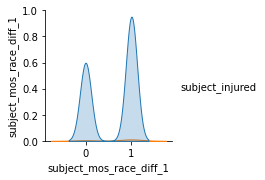

In [94]:
plot_features(df_X[['subject_injured','subject_mos_race_diff_1']])

### Pair plots of target variable and non-NYPD subject's gender

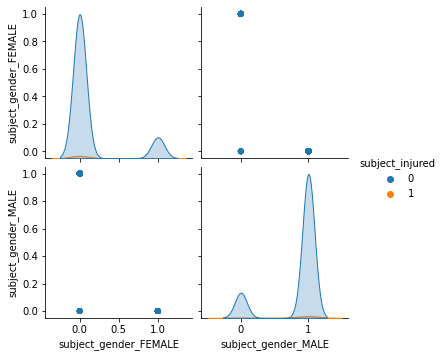

In [95]:
plot_features(df_X[['subject_injured','subject_gender_FEMALE', 'subject_gender_MALE']])

# Model Preparation

### train-validate/test split on randomly selected groups of suspects

In [125]:
# scale numeric features
cols_to_scale = ['num_members','num_members_injured','num_subjects','subject_age',]
scaler = StandardScaler()
df_X[cols_to_scale] = scaler.fit_transform(df_X[cols_to_scale])

np.random.seed(42)
total_subjects = df_X['subject_id'].unique() 
test_subjects = np.random.choice(total_subjects, size=int(total_subjects.shape[0] * .20))

df_X_tr, df_X_te = df_X[~df_X['subject_id'].isin(test_subjects)], df_X[df_X['subject_id'].isin(test_subjects)]

y_tr, y_te = df_X_tr['subject_injured'], df_X_te['subject_injured']
X_tr, X_te = df_X_tr.drop(['subject_id','tri_incident_number','subject_injured'],axis=1), \
             df_X_te.drop(['subject_id','tri_incident_number','subject_injured'],axis=1)

import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 48, 0 : n_neg} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_tr_rs, y_tr_rs = ROS.fit_resample(X_tr, y_tr)

### create helper function for running, fitting and validating logistic regression models

In [126]:
def lr_model_cross_validate(X,y):
    
    scoring_metrics = {'f2_score': make_scorer(fbeta_score, beta=2),'rec': 'recall'}
    
    lr = LogisticRegression(solver='lbfgs',max_iter=10000)
    lr.fit(X, y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)
    cv_results = cross_validate(lr, X, y, cv=kf, scoring=scoring_metrics)
    
    # Report results
    
    print(f"recall: {(cv_results['test_rec'])}")
    print("")
    print(f"mean recall: {(np.mean(cv_results['test_rec'])):.3f}")
    print("")
    print(f"f2 score: {(cv_results['test_f2_score'])}")
    print("")
    print(f"mean f2 score: {(np.mean(cv_results['test_f2_score'])):.3f}")

In [156]:
X_tr.columns

Index(['subject_used_force_Y', 'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',


### baseline model with all 11 features (not 'subject_used_force_Y') and no over-sampling

In [157]:
lr_model_cross_validate(X_tr[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']],y_tr)

recall: [0.11627907 0.03921569 0.05128205 0.         0.09302326]

mean recall: 0.060

f2 score: [0.1396648  0.04830918 0.0621118  0.         0.11299435]

mean f2 score: 0.073


### baseline model with 11 features (not 'subject_used_force_Y') and over-sampling

In [158]:
lr_model_cross_validate(X_tr_rs[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']],y_tr_rs)

recall: [0.65308151 0.63916016 0.6354067  0.63248283 0.621881  ]

mean recall: 0.636

f2 score: [0.65765766 0.64641975 0.64786808 0.63976573 0.6371055 ]

mean f2 score: 0.646


### plot the roc curve for the baseline model with over-sampling

In [163]:
# instantiate the model and fit it (do it again, since when we did it above, it was within a function)
lr = LogisticRegression(solver='lbfgs',max_iter=10000)
lr.fit(X_tr_rs[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']], y_tr_rs)

LogisticRegression(max_iter=10000)

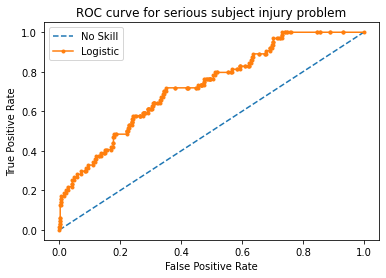

ROC AUC score =  0.7289310409519725


In [165]:
# calculate roc curve and plot it
fpr, tpr, thresholds = roc_curve(y_te, lr.predict_proba(X_te[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']])[:,1]) # lr.predict_proba(X_te)[:,1] means use probabilities for the positive outcome only
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for serious subject injury problem')
plt.legend()
# show the plot
plt.show()
print("ROC AUC score = ", roc_auc_score(y_te, lr.predict_proba(X_te[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']])[:,1]))

In [166]:
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.471667


In [169]:
# get coefficients
coefficients = lr.coef_[0]

# create df of features and their importance levels
lr_feature_coeffs = pd.DataFrame({'features': X_tr_rs[['forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket',
       'num_members_injured', 'patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI',
       'subject_race_AMER INDIAN', 'subject_race_ASIAN', 'subject_race_BLACK',
       'subject_race_HISPANIC', 'subject_race_UNK/OTH',
       'force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)', 'num_members',
       'subject_age', 'subject_mos_race_diff_1', 'num_subjects',
       'subject_gender_FEMALE', 'subject_gender_MALE']].columns,
                   'coefficients': coefficients}).\
                    sort_values('coefficients', ascending = False)
lr_feature_coeffs

,features,coefficients
0,forcetype_Firearm,3.774889
37,basis_encounter_SEARCH WARRANT,2.269695
31,basis_encounter_IN CUSTODY INJURY,2.121112
19,force_against_mos_Cutting Instrument,1.418957
24,basis_encounter_AMBUSH OF MEMBER,0.955929
22,force_against_mos_Impact Weapon,0.874752
1,forcetype_Impact Weapon,0.872786
21,force_against_mos_Firearm,0.535658
26,basis_encounter_CRIME/VIOLATION IN PROGRESS,0.400304
41,"basis_encounter_WANTED SUSPECT (E.G. WARRANT, ...",0.353452


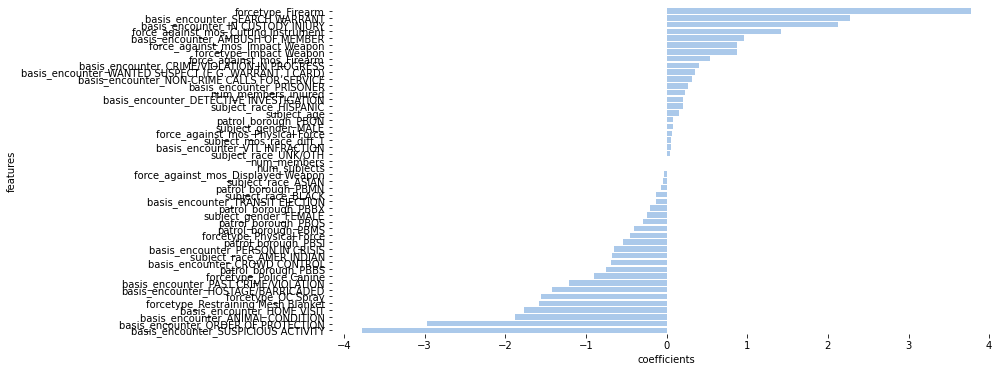

In [170]:
# plot the features and their importance levels
f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="coefficients", y="features", data=lr_feature_coeffs,
            label="Feature Coefficients", color="b")
sns.despine(left=True, bottom=True)
#plt.savefig('mvp.png',bbox_inches='tight')

# More logistic regression models, all using over-sampling and different combinations of features

**one feature (mos' type of force used)**

In [171]:
lr_model_cross_validate(X_tr_rs[['forcetype_Firearm','forcetype_Impact Weapon',
                                 'forcetype_OC Spray','forcetype_Physical Force',
                                 'forcetype_Police Canine','forcetype_Restraining Mesh Blanket']],y_tr_rs)

recall: [0.35934394 0.38378906 0.3784689  0.37684004 0.37907869]

mean recall: 0.376

f2 score: [0.39413432 0.4176852  0.41404941 0.41122296 0.41548333]

mean f2 score: 0.411


**one feature (type of force used by non-NYPD subject against mos)**

In [172]:
lr_model_cross_validate(X_tr_rs[['force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force']],y_tr_rs)

recall: [0.09940358 0.11865234 0.10430622 0.11089303 0.11996161]

mean recall: 0.111

f2 score: [0.12056909 0.14344746 0.12649414 0.13426806 0.14462571]

mean f2 score: 0.134


** two features (type of force used by non-NYPD subject against mos and type of force used by mos)**

In [173]:
lr_model_cross_validate(X_tr_rs[['force_against_mos_Cutting Instrument',
       'force_against_mos_Displayed Weapon', 'force_against_mos_Firearm',
       'force_against_mos_Impact Weapon', 'force_against_mos_Physical Force',
       'forcetype_Firearm','forcetype_Impact Weapon',
       'forcetype_OC Spray','forcetype_Physical Force',
       'forcetype_Police Canine','forcetype_Restraining Mesh Blanket']],y_tr_rs)

recall: [0.37027833 0.3671875  0.35980861 0.36997056 0.36372361]

mean recall: 0.366

f2 score: [0.4044956  0.40391019 0.39779941 0.40673212 0.40225005]

mean f2 score: 0.403


**all 4 numeric features**

In [174]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age']],y_tr_rs)

recall: [0.46272366 0.45117188 0.43588517 0.45436703 0.4256238 ]

mean recall: 0.446

f2 score: [0.48054093 0.47094801 0.45880338 0.47211176 0.44770846]

mean f2 score: 0.466


**all 4 numeric features, type of force used by mos, type of force used by non-NYPD subject against mos**

In [175]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'force_against_mos_Cutting Instrument','force_against_mos_Displayed Weapon',
                                 'force_against_mos_Firearm','force_against_mos_Impact Weapon',
                                 'force_against_mos_Physical Force','forcetype_Firearm',
                                 'forcetype_Impact Weapon','forcetype_OC Spray',
                                 'forcetype_Physical Force','forcetype_Police Canine',
                                 'forcetype_Restraining Mesh Blanket']],y_tr_rs)

recall: [0.39015905 0.38916016 0.38803828 0.37929342 0.39011516]

mean recall: 0.387

f2 score: [0.42395766 0.42281167 0.42336605 0.4134132  0.42574361]

mean f2 score: 0.422


**all 4 numeric features and whether non-NYPD subject used force against mos**

In [176]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y']],y_tr_rs)

recall: [0.4612326  0.45117188 0.45263158 0.45829244 0.43138196]

mean recall: 0.451

f2 score: [0.47874536 0.47090001 0.47404289 0.47575387 0.4528511 ]

mean f2 score: 0.470


**all 4 numeric features, whether non-NYPD subject used force against mos, non-NYPD subject's gender**

In [178]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y','subject_gender_FEMALE', 'subject_gender_MALE']],y_tr_rs)

recall: [0.54224652 0.54980469 0.50813397 0.54317959 0.52111324]

mean recall: 0.533

f2 score: [0.55012102 0.55914192 0.52253493 0.54987085 0.5339233 ]

mean f2 score: 0.543


**all 4 numeric features, whether non-NYPD subject used force against mos, non-NYPD subject's gender and patrol borough**

In [182]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y','subject_gender_FEMALE', 'subject_gender_MALE',
                                'patrol_borough_PBBS', 'patrol_borough_PBBX','patrol_borough_PBMN',
                                 'patrol_borough_PBMS', 'patrol_borough_PBQN','patrol_borough_PBQS',
                                 'patrol_borough_PBSI']],y_tr_rs)

recall: [0.56212724 0.57519531 0.57033493 0.57752699 0.52495202]

mean recall: 0.562

f2 score: [0.56403351 0.57671595 0.57723971 0.5781511  0.53444064]

mean f2 score: 0.566


**all 4 numeric features, whether non-NYPD subject used force against mos, non-NYPD subject's gender and type of force used by mos**

In [183]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y','subject_gender_FEMALE', 'subject_gender_MALE',
                                'forcetype_Firearm', 'forcetype_Impact Weapon',
       'forcetype_OC Spray', 'forcetype_Physical Force',
       'forcetype_Police Canine', 'forcetype_Restraining Mesh Blanket']],y_tr_rs)

recall: [0.43091451 0.41943359 0.42679426 0.43424926 0.43234165]

mean recall: 0.429

f2 score: [0.46180888 0.45186744 0.45960429 0.4647621  0.46582566]

mean f2 score: 0.461


**all 4 numeric features, whether non-NYPD subject used force against mos, non-NYPD subject's gender and basis for encounter**

In [187]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y','subject_gender_FEMALE', 'subject_gender_MALE',
                                'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
                                 'basis_encounter_CRIME/VIOLATION IN PROGRESS','basis_encounter_CROWD CONTROL',
                                 'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
                                 'basis_encounter_HOSTAGE/BARRICADED','basis_encounter_IN CUSTODY INJURY',
                                 'basis_encounter_NON-CRIME CALLS FOR SERVICE','basis_encounter_ORDER OF PROTECTION',
                                 'basis_encounter_PAST CRIME/VIOLATION','basis_encounter_PERSON IN CRISIS',
                                 'basis_encounter_PRISONER','basis_encounter_SEARCH WARRANT',
                                 'basis_encounter_SUSPICIOUS ACTIVITY','basis_encounter_TRANSIT EJECTION',
                                 'basis_encounter_VTL INFRACTION',
                                 'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']],y_tr_rs)

recall: [0.65805169 0.66064453 0.66076555 0.64131501 0.62140115]

mean recall: 0.648

f2 score: [0.64221964 0.64973108 0.65172251 0.63036558 0.61991383]

mean f2 score: 0.639


**all 4 numeric features, whether non-NYPD subject used force against mos, non-NYPD subject's gender, basis for encounter and patrol borough**

In [188]:
lr_model_cross_validate(X_tr_rs[['num_members','num_members_injured','num_subjects','subject_age',
                                'subject_used_force_Y','subject_gender_FEMALE', 'subject_gender_MALE',
                                'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
                                 'basis_encounter_CRIME/VIOLATION IN PROGRESS','basis_encounter_CROWD CONTROL',
                                 'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
                                 'basis_encounter_HOSTAGE/BARRICADED','basis_encounter_IN CUSTODY INJURY',
                                 'basis_encounter_NON-CRIME CALLS FOR SERVICE','basis_encounter_ORDER OF PROTECTION',
                                 'basis_encounter_PAST CRIME/VIOLATION','basis_encounter_PERSON IN CRISIS',
                                 'basis_encounter_PRISONER','basis_encounter_SEARCH WARRANT',
                                 'basis_encounter_SUSPICIOUS ACTIVITY','basis_encounter_TRANSIT EJECTION',
                                 'basis_encounter_VTL INFRACTION',
                                 'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)','patrol_borough_PBBS', 
                                 'patrol_borough_PBBX','patrol_borough_PBMN','patrol_borough_PBMS', 
                                 'patrol_borough_PBQN','patrol_borough_PBQS','patrol_borough_PBSI']],y_tr_rs)

recall: [0.68091451 0.67724609 0.65741627 0.67860648 0.65547025]

mean recall: 0.670

f2 score: [0.66472586 0.66459032 0.65223583 0.66343663 0.65060011]

mean f2 score: 0.659


**basis for encounter**

In [198]:
lr_model_cross_validate(X_tr_rs[['basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
                                 'basis_encounter_CRIME/VIOLATION IN PROGRESS','basis_encounter_CROWD CONTROL',
                                 'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
                                 'basis_encounter_HOSTAGE/BARRICADED','basis_encounter_IN CUSTODY INJURY',
                                 'basis_encounter_NON-CRIME CALLS FOR SERVICE','basis_encounter_ORDER OF PROTECTION',
                                 'basis_encounter_PAST CRIME/VIOLATION','basis_encounter_PERSON IN CRISIS',
                                 'basis_encounter_PRISONER','basis_encounter_SEARCH WARRANT',
                                 'basis_encounter_SUSPICIOUS ACTIVITY','basis_encounter_TRANSIT EJECTION',
                                 'basis_encounter_VTL INFRACTION',
                                 'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']],y_tr_rs)

recall: [0.80666004 0.81933594 0.81004785 0.80863592 0.80998081]

mean recall: 0.811

f2 score: [0.73833136 0.75361538 0.74798975 0.74240923 0.74849237]

mean f2 score: 0.746


**patrol borough**

In [194]:
lr_model_cross_validate(X_tr_rs[['patrol_borough_PBBS', 'patrol_borough_PBBX',
       'patrol_borough_PBMN', 'patrol_borough_PBMS', 'patrol_borough_PBQN',
       'patrol_borough_PBQS', 'patrol_borough_PBSI']],y_tr_rs)

recall: [0.42296223 0.41943359 0.44736842 0.42836114 0.42610365]

mean recall: 0.429

f2 score: [0.44047619 0.43755094 0.46871867 0.44732527 0.44533601]

mean f2 score: 0.448


### Top performing model: that which uses only one feature, basis for encounter

In [199]:
# instantiate the top performing model with feature = basis for encounter
lr_basis_encounter = LogisticRegression(solver='lbfgs',max_iter=10000)
lr_basis_encounter.fit(X_tr_rs[['basis_encounter_AMBUSH OF MEMBER','basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']], y_tr_rs)

LogisticRegression(max_iter=10000)

In [203]:
# get coefficients
coeffs = lr_basis_encounter.coef_[0]

# create df of features and their importance levels
lr_feature_coeffs = pd.DataFrame({'features': X_tr_rs[[
       'basis_encounter_AMBUSH OF MEMBER', 'basis_encounter_ANIMAL CONDITION',
       'basis_encounter_CRIME/VIOLATION IN PROGRESS',
       'basis_encounter_CROWD CONTROL',
       'basis_encounter_DETECTIVE INVESTIGATION', 'basis_encounter_HOME VISIT',
       'basis_encounter_HOSTAGE/BARRICADED',
       'basis_encounter_IN CUSTODY INJURY',
       'basis_encounter_NON-CRIME CALLS FOR SERVICE',
       'basis_encounter_ORDER OF PROTECTION',
       'basis_encounter_PAST CRIME/VIOLATION',
       'basis_encounter_PERSON IN CRISIS', 'basis_encounter_PRISONER',
       'basis_encounter_SEARCH WARRANT', 'basis_encounter_SUSPICIOUS ACTIVITY',
       'basis_encounter_TRANSIT EJECTION', 'basis_encounter_VTL INFRACTION',
       'basis_encounter_WANTED SUSPECT (E.G. WARRANT, I CARD)']].columns,
                   'coefficients': coeffs}).\
                    sort_values('coefficients', ascending = False)
lr_feature_coeffs

,features,coefficients
13,basis_encounter_SEARCH WARRANT,2.244778
0,basis_encounter_AMBUSH OF MEMBER,1.916932
7,basis_encounter_IN CUSTODY INJURY,1.556788
17,"basis_encounter_WANTED SUSPECT (E.G. WARRANT, ...",0.273767
5,basis_encounter_HOME VISIT,0.201244
2,basis_encounter_CRIME/VIOLATION IN PROGRESS,0.180848
8,basis_encounter_NON-CRIME CALLS FOR SERVICE,0.175976
12,basis_encounter_PRISONER,-0.007133
4,basis_encounter_DETECTIVE INVESTIGATION,-0.143965
16,basis_encounter_VTL INFRACTION,-0.431232
